# Single-Scale Model


## Package

In [1]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import cv2
import random
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from sklearn import metrics
import pandas as pd

tf.enable_eager_execution()

## Function

In [0]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im
  
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

def apply_mask(im, mask, color= 1):
    masked = np.zeros((im.shape[0], im.shape[1]))
    for x,y in mask: masked[x][y] = color
    return masked
  
def create_folder(slide_path, level, mode = 'train'):
    BASE_DIR = os.getcwd()
    
    img_num = slide_path.split('_')[1].strip(".tif")
    
    DATA = 'data/'
    IMG_NUM_FOLDER = img_num + '/'
    LEVEL_FOLDER = str(level) + '/'
    
    DATA_DIR = os.path.join(BASE_DIR, DATA)
    IMG_NUM_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER)
    IMG_NUM_LEVEL_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER)
       
    if not os.path.exists(DATA_DIR):
        os.mkdir(DATA_DIR)
    if not os.path.exists(IMG_NUM_DIR):
        os.mkdir(IMG_NUM_DIR)
    if not os.path.exists(IMG_NUM_LEVEL_DIR):
        os.mkdir(IMG_NUM_LEVEL_DIR)
        
    if mode == 'train':
        TUMOR_FOLDER = 'tumor/'
        NO_TUMOR_FOLDER = 'no_tumor/'
        TUMOR_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER, TUMOR_FOLDER)
        NO_TUMOR_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER, NO_TUMOR_FOLDER)
        if not os.path.exists(TUMOR_DIR):
            os.mkdir(TUMOR_DIR)
        if not os.path.exists(NO_TUMOR_DIR):
            os.mkdir(NO_TUMOR_DIR)
        return DATA + IMG_NUM_FOLDER + LEVEL_FOLDER + TUMOR_FOLDER, DATA + IMG_NUM_FOLDER + LEVEL_FOLDER + NO_TUMOR_FOLDER
  
        
    if mode == 'test':
        TISSUE_FOLDER = 'tissue_only/'
        ALL_FOLDER = 'all/'
        TISSUE_DIR  = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER, TISSUE_FOLDER)
        ALL_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER, ALL_FOLDER)
        if not os.path.exists(TISSUE_DIR):
            os.mkdir(TISSUE_DIR)
        if not os.path.exists(ALL_DIR):
            os.mkdir(ALL_DIR)
        return DATA + IMG_NUM_FOLDER + LEVEL_FOLDER + TUMOR_FOLDER, DATA + IMG_NUM_FOLDER + LEVEL_FOLDER + ALL_FOLDER
  
  
def save_training_data(im, tumor_mask, tissue_mask,  num_pixels, level, slide_path):
    x,y = im.shape[0], im.shape[1]
    x_count, y_count = int(np.ceil(x / num_pixels)), int(np.ceil(y/num_pixels))
    tumor_folder, no_tumor_folder = create_folder(slide_path, level)
    try:
        for i in range(x_count):
            for j in range(y_count):
                im_slice = np.zeros((num_pixels, num_pixels, 3))
                tissue_mask_slice = np.zeros((num_pixels, num_pixels))
                tumor_mask_slice = np.zeros((num_pixels, num_pixels))
                string_name = 'img_level%d_'%(level) + str(i * y_count + j)

                if i == x_count-1:
                    ub_x = x
                    assign_x = x - (x_count-1)*num_pixels
                else:
                    ub_x = (i+1) * num_pixels
                    assign_x = num_pixels

                if j == y_count-1:
                    ub_y = y
                    assign_y = y - (y_count-1)*num_pixels
                else:
                    ub_y = (j+1) * num_pixels
                    assign_y = num_pixels       
                
                tissue_mask_slice[0:assign_x, 0:assign_y] = tissue_mask[(i*num_pixels) :ub_x, (j * num_pixels) :ub_y]
                try:
                    if np.mean(tissue_mask_slice) > 0.7:
                        im_slice[0:assign_x, 0:assign_y, :] = im[(i*num_pixels) :ub_x, (j * num_pixels) :ub_y, :]
                        tumor_mask_slice[0:assign_x, 0:assign_y] = tumor_mask[(i*num_pixels) :ub_x, (j * num_pixels) :ub_y]

                        if np.max(tumor_mask_slice) > 0:
                            im_file_name = tumor_folder + string_name + ".jpg" 
                        else:
                            im_file_name = no_tumor_folder + string_name + ".jpg"
                        
                        cv2.imwrite(im_file_name, im_slice)
                except Exception as oerr:
                    print('Error with saving:', oerr)
    except Exception as oerr:
        print('Error with slicing:', oerr) 
        
def save_test_data(im, tissue_mask, num_pixels, level_num, slide_path):
    x,y = im.shape[0], im.shape[1]
    x_count, y_count = int(np.ceil(x / num_pixels)), int(np.ceil(y/num_pixels))
    tissue_folder, all_folder = create_folder(slide_path, mode = 'test')
    try:
        for i in range(x_count):
            for j in range(y_count):
                im_slice = np.zeros((num_pixels, num_pixels, 3))
                im_tissue_slice = np.zeros((num_pixels, num_pixels, 3))
                tissue_mask_slice = np.zeros((num_pixels, num_pixels))
                string_name = 'img_level%d_'%(level_num) + str(i * y_count + j)

                if i == x_count-1:
                    ub_x = x
                    assign_x = x - (x_count-1)*num_pixels
                else:
                    ub_x = (i+1) * num_pixels
                    assign_x = num_pixels

                if j == y_count-1:
                    ub_y = y
                    assign_y = y - (y_count-1)*num_pixels
                else:
                    ub_y = (j+1) * num_pixels
                    assign_y = num_pixels       

                tissue_mask_slice[0:assign_x, 0:assign_y] = tissue_mask[(i*num_pixels) :ub_x, (j * num_pixels) :ub_y]

                try:
                    if np.mean(tissue_mask_slice) > 0.7:
                        im_tissue_slice[0:assign_x, 0:assign_y, :] = im[(i*num_pixels) :ub_x, (j * num_pixels) :ub_y, :]
                        im_file_name_tissue = tissue_folder + string_name + ".jpg"
                        cv2.imwrite(im_file_name_tissue, im_tissue_slice)
                    im_slice[0:assign_x, 0:assign_y, :] = im[(i*num_pixels) :ub_x, (j * num_pixels) :ub_y, :]
                    im_file_name_all = all_folder + string_name + ".jpg"
                    cv2.imwrite(im_file_name_all, im_slice)
                except Exception as oerr:
                    print('Error with saving:', oerr)
    except Exception as oerr:
        print('Error with slicing:', oerr)

        
def LoadImage(path):
    image = tf.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(image, [128, 128])
    image /= 255.0
    return image

def evaluate_result(predictions, tissue_regions, mask_image):
    scale = int(mask_image.shape[0]/predictions.shape[0])
    predictions_scaled = np.kron(predictions, np.ones((scale, scale)))
    predictions_scaled = predictions_scaled.reshape(-1)
    
    mask_image = mask_image.reshape(-1)
    tissue_regions = tissue_regions.reshape(-1)
  
    predictions_scaled = predictions_scaled[tissue_regions == 1]
    mask_image = mask_image[tissue_regions == 1]
  
    p = metrics.precision_score(mask_image, predictions_scaled)
    print('Precision:', p)
    r = metrics.recall_score(mask_image, predictions_scaled)
    print('Recall:', r)
    f = metrics.f1_score(mask_image, predictions_scaled)
    print('F1:', f)
    auc = metrics.roc_auc_score(mask_image, predictions_scaled)
    print('AUC score:', auc)
  
    fpr, tpr, _ = metrics.roc_curve(mask_image, predictions_scaled)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
  
    cm = metrics.confusion_matrix(mask_image, predictions_scaled)
    df_cm = pd.DataFrame(cm,columns = ['Predicted 0', 'Predicted 1'])
    df_cm.index = ['Reality 0', 'Reality 1']
    print('Confusion Matrix:')
    df_cm = pd.DataFrame(cm,columns = ['Predicted 0', 'Predicted 1'])
    df_cm.index = ['Reality 0', 'Reality 1']
    print(df_cm)
    df_cm_percent = df_cm
    df_cm_percent['Predicted 0'] = 100*df_cm_percent['Predicted 0']/len(mask_image)
    df_cm_percent['Predicted 1'] = 100*df_cm_percent['Predicted 1']/len(mask_image)
    print(df_cm_percent)

# Data

## Downloading Data

In [0]:
# Download an example slide and tumor mask
# Note: these are hosted on Google Cloud Storage.
# The remainder are in a Google Drive folder, linked above.

slide_path_091 = 'tumor_091.tif'
tumor_mask_path_091 = 'tumor_091_mask.tif'

slide_url_091 = 'https://storage.googleapis.com/applied-dl/%s' % slide_path_091
mask_url_091 = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path_091

# Download the whole slide image
if not os.path.exists(slide_path_091):
  !curl -O $slide_url_091

# Download the tumor mask
if not os.path.exists(tumor_mask_path_091):
  !curl -O $mask_url_091

In [5]:
slide_091 = open_slide(slide_path_091)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path_091, 
                                                        slide_091.level_dimensions[0][0], 
                                                        slide_091.level_dimensions[0][1]))

tumor_mask_091 = open_slide(tumor_mask_path_091)
print ("Read tumor mask from %s" % (tumor_mask_path_091))

print("Slide includes %d levels" % len(slide_091.level_dimensions))
for i in range(len(slide_091.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide_091.level_dimensions[i], 
                                                             slide_091.level_downsamples[i]))
    assert tumor_mask_091.level_dimensions[i][0] == slide_091.level_dimensions[i][0]
    assert tumor_mask_091.level_dimensions[i][1] == slide_091.level_dimensions[i][1]

width, height = slide_091.level_dimensions[7]
assert width * slide_091.level_downsamples[7] == slide_091.level_dimensions[0][0]
assert height * slide_091.level_downsamples[7] == slide_091.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
Slide includes 8 levels
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [6]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

def apply_mask(im, mask, color= 1):
    masked = np.zeros((im.shape[0], im.shape[1]))
    for x,y in mask: masked[x][y] = color
    return masked

levelNO = 3 # level number
slide_image_091_L3 = read_slide(slide_091, 
                         x=0, 
                         y=0, 
                         level=levelNO, 
                         width=slide_091.level_dimensions[levelNO][0], 
                         height=slide_091.level_dimensions[levelNO][1])

mask_image_091_L3 = read_slide(tumor_mask_091, 
                        x=0, 
                        y=0, 
                        level=levelNO, 
                        width=slide_091.level_dimensions[levelNO][0], 
                        height=slide_091.level_dimensions[levelNO][1])

mask_image_091_L3 = mask_image_091_L3[:,:,0] 

tissue_pixels_091_L3 = list(find_tissue_pixels(slide_image_091_L3))

percent_tissue_091_L3 = len(tissue_pixels_091_L3) / float(slide_image_091_L3.shape[0] * slide_image_091_L3.shape[0]) * 100

print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels_091_L3), percent_tissue_091_L3))

tissue_regions_091_L3 = apply_mask(slide_image_091_L3, tissue_pixels_091_L3)

13344403 tissue_pixels pixels (29.6 percent of the image)


In [0]:
def create_folder(slide_path, level, mode = 'train'):
    BASE_DIR = os.getcwd()
    
    img_num = slide_path.split('_')[1].strip(".tif")
    
    DATA = 'data/'
    IMG_NUM_FOLDER = img_num + '/'
    LEVEL_FOLDER = str(level) + '/'
    
    DATA_DIR = os.path.join(BASE_DIR, DATA)
    IMG_NUM_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER)
    IMG_NUM_LEVEL_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER)
       
    if not os.path.exists(DATA_DIR):
        os.mkdir(DATA_DIR)
    if not os.path.exists(IMG_NUM_DIR):
        os.mkdir(IMG_NUM_DIR)
    if not os.path.exists(IMG_NUM_LEVEL_DIR):
        os.mkdir(IMG_NUM_LEVEL_DIR)
        
    if mode == 'train':
        TUMOR_FOLDER = 'tumor/'
        NO_TUMOR_FOLDER = 'no_tumor/'
        TUMOR_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER, TUMOR_FOLDER)
        NO_TUMOR_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER, NO_TUMOR_FOLDER)
        if not os.path.exists(TUMOR_DIR):
            os.mkdir(TUMOR_DIR)
        if not os.path.exists(NO_TUMOR_DIR):
            os.mkdir(NO_TUMOR_DIR)
        return DATA + IMG_NUM_FOLDER + LEVEL_FOLDER + TUMOR_FOLDER, DATA + IMG_NUM_FOLDER + LEVEL_FOLDER + NO_TUMOR_FOLDER
  
        
    if mode == 'test':
        TISSUE_FOLDER = 'tissue_only/'
        ALL_FOLDER = 'all/'
        TISSUE_DIR  = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER, TISSUE_FOLDER)
        ALL_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER, ALL_FOLDER)
        if not os.path.exists(TISSUE_DIR):
            os.mkdir(TISSUE_DIR)
        if not os.path.exists(ALL_DIR):
            os.mkdir(ALL_DIR)
        return DATA + IMG_NUM_FOLDER + LEVEL_FOLDER + TISSUE_FOLDER, DATA + IMG_NUM_FOLDER + LEVEL_FOLDER + ALL_FOLDER

def save_training_data(im, tumor_mask, tissue_mask,  num_pixels, level, slide_path):
    x,y = im.shape[0], im.shape[1]
    x_count, y_count = int(np.ceil(x / num_pixels)), int(np.ceil(y/num_pixels))
    tumor_folder, no_tumor_folder = create_folder(slide_path, level)
    try:
        for i in range(x_count):
            for j in range(y_count):
                im_slice = np.zeros((num_pixels, num_pixels, 3))
                tissue_mask_slice = np.zeros((num_pixels, num_pixels))
                tumor_mask_slice = np.zeros((num_pixels, num_pixels))
                string_name = 'img_level%d_'%(level) + str(i * y_count + j)

                if i == x_count-1:
                    ub_x = x
                    assign_x = x - (x_count-1)*num_pixels
                else:
                    ub_x = (i+1) * num_pixels
                    assign_x = num_pixels

                if j == y_count-1:
                    ub_y = y
                    assign_y = y - (y_count-1)*num_pixels
                else:
                    ub_y = (j+1) * num_pixels
                    assign_y = num_pixels       
                
                tissue_mask_slice[0:assign_x, 0:assign_y] = tissue_mask[(i*num_pixels) :ub_x, (j * num_pixels) :ub_y]
                try:
                    if np.mean(tissue_mask_slice) > 0.7:
                        im_slice[0:assign_x, 0:assign_y, :] = im[(i*num_pixels) :ub_x, (j * num_pixels) :ub_y, :]
                        tumor_mask_slice[0:assign_x, 0:assign_y] = tumor_mask[(i*num_pixels) :ub_x, (j * num_pixels) :ub_y]

                        if np.max(tumor_mask_slice) > 0:
                            im_file_name = tumor_folder + string_name + ".jpg" 
                        else:
                            im_file_name = no_tumor_folder + string_name + ".jpg"
                        
                        cv2.imwrite(im_file_name, im_slice)
                except Exception as oerr:
                    print('Error with saving:', oerr)
    except Exception as oerr:
        print('Error with slicing:', oerr) 


num_pixels = 64
save_training_data(slide_image_091_L3, mask_image_091_L3, tissue_regions_091_L3, num_pixels, levelNO, slide_path_091)

## Preparing Training Data

In [0]:
BasePath = '/content/data/'
img_num = '091'
ImagePaths_tumor_091_L3 = [BasePath + img_num + '/'+str(levelNO)+'/'+ '/tumor/' + x for x in os.listdir(BasePath + img_num + '/'+str(levelNO)+'/' + '/tumor')]
ImagePaths_notumor_091_L3 = [BasePath + img_num + '/'+str(levelNO)+'/'+ '/no_tumor/' + x for x in os.listdir(BasePath + img_num + '/'+str(levelNO)+'/' + '/no_tumor')]
num_tumor_091_L3 = len(ImagePaths_tumor_091_L3)
ImagePaths_notumor_091_L3 = ImagePaths_notumor_091_L3[0:num_tumor_091_L3]

ImagePaths_091_L3 = np.array([str(path) for path in ImagePaths_tumor_091_L3 + ImagePaths_notumor_091_L3])
ImageLabels_091_L3 = np.array([1]*num_tumor_091_L3 + [0]*num_tumor_091_L3)
shuffle_index = np.arange(len(ImagePaths_091_L3))
np.random.shuffle(shuffle_index)
ImageLabels_091_L3 = ImageLabels_091_L3[shuffle_index]
ImagePaths_091_L3 = ImagePaths_091_L3[shuffle_index]

In [0]:
def LoadImage(path):
    image = tf.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(image, [128, 128])
    image /= 255.0
    return image

path_dataset = tf.data.Dataset.from_tensor_slices(ImagePaths_091_L3)
image_dataset_091_L3 = path_dataset.map(LoadImage, num_parallel_calls=8)

label_dataset_091_L3 = tf.data.Dataset.from_tensor_slices(tf.cast(ImageLabels_091_L3, tf.int64))
dataset_091_L3 = tf.data.Dataset.zip((image_dataset_091_L3, label_dataset_091_L3))

# VGG16

## Train

In [10]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

model1 = models.Sequential()
model1.add(base_model)
model1.add(layers.Flatten())
model1.add(layers.Dense(32, activation='relu'))
model1.add(layers.Dense(2, activation='softmax'))
model1.summary()

model1.compile(optimizer=tf.train.AdamOptimizer(),
               loss=tf.keras.losses.sparse_categorical_crossentropy,
               metrics=['acc'])

58892288/58889256 [==============================] - 5s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                262176    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 14,976,930
Trainable params: 262,242
Non-trainable params: 14,714,688
_________________________________________________________________


{'loss': [0.6555885129115161, 0.5159766954534194, 0.42201758658184724, 0.37582169385517344, 0.3309189440572963, 0.34911518763093385, 0.32094566348721, 0.23516108446261463], 'acc': [0.6525735294117647, 0.7573529411764706, 0.7996323529411765, 0.8474264705882353, 0.875, 0.8455882352941176, 0.8694852941176471, 0.9154411764705882]}


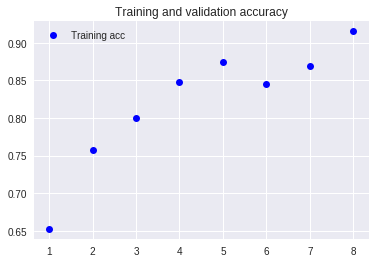

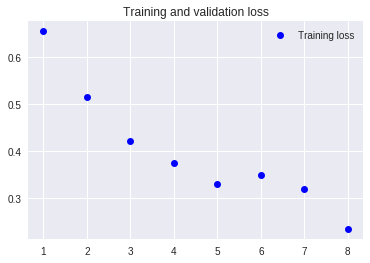

In [0]:
print(history1.history)

acc = history1.history['acc']
loss = history1.history['loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Test

### Preparing Testing Data

In [0]:
def create_folder(slide_path, level, mode = 'train'):
    BASE_DIR = os.getcwd()
    
    img_num = slide_path.split('_')[1].strip(".tif")
    
    DATA = 'data/'
    IMG_NUM_FOLDER = img_num + '/'
    LEVEL_FOLDER = str(level) + '/'
    
    DATA_DIR = os.path.join(BASE_DIR, DATA)
    IMG_NUM_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER)
    IMG_NUM_LEVEL_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER)
       
    if not os.path.exists(DATA_DIR):
        os.mkdir(DATA_DIR)
    if not os.path.exists(IMG_NUM_DIR):
        os.mkdir(IMG_NUM_DIR)
    if not os.path.exists(IMG_NUM_LEVEL_DIR):
        os.mkdir(IMG_NUM_LEVEL_DIR)
        
    if mode == 'train':
        TUMOR_FOLDER = 'tumor/'
        NO_TUMOR_FOLDER = 'no_tumor/'
        TUMOR_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER, TUMOR_FOLDER)
        NO_TUMOR_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER, NO_TUMOR_FOLDER)
        if not os.path.exists(TUMOR_DIR):
            os.mkdir(TUMOR_DIR)
        if not os.path.exists(NO_TUMOR_DIR):
            os.mkdir(NO_TUMOR_DIR)
        return DATA + IMG_NUM_FOLDER + LEVEL_FOLDER + TUMOR_FOLDER, DATA + IMG_NUM_FOLDER + LEVEL_FOLDER + NO_TUMOR_FOLDER
  
        
    if mode == 'test':
        TISSUE_FOLDER = 'tissue_only/'
        ALL_FOLDER = 'all/'
        TISSUE_DIR  = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER, TISSUE_FOLDER)
        ALL_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER, ALL_FOLDER)
        if not os.path.exists(TISSUE_DIR):
            os.mkdir(TISSUE_DIR)
        if not os.path.exists(ALL_DIR):
            os.mkdir(ALL_DIR)
        return DATA + IMG_NUM_FOLDER + LEVEL_FOLDER + TISSUE_FOLDER, DATA + IMG_NUM_FOLDER + LEVEL_FOLDER + ALL_FOLDER

def save_test_data(im, tissue_mask, num_pixels, level_num, slide_path):
    x,y = im.shape[0], im.shape[1]
    x_count, y_count = int(np.ceil(x / num_pixels)), int(np.ceil(y/num_pixels))
    tissue_folder, all_folder = create_folder(slide_path, level_num, mode = 'test')
    try:
        for i in range(x_count):
            for j in range(y_count):
                im_slice = np.zeros((num_pixels, num_pixels, 3))
                im_tissue_slice = np.zeros((num_pixels, num_pixels, 3))
                tissue_mask_slice = np.zeros((num_pixels, num_pixels))
                string_name = 'img_level%d_'%(level_num) + str(i * y_count + j)

                if i == x_count-1:
                    ub_x = x
                    assign_x = x - (x_count-1)*num_pixels
                else:
                    ub_x = (i+1) * num_pixels
                    assign_x = num_pixels

                if j == y_count-1:
                    ub_y = y
                    assign_y = y - (y_count-1)*num_pixels
                else:
                    ub_y = (j+1) * num_pixels
                    assign_y = num_pixels       

                tissue_mask_slice[0:assign_x, 0:assign_y] = tissue_mask[(i*num_pixels) :ub_x, (j * num_pixels) :ub_y]

                try:
                    if np.mean(tissue_mask_slice) > 0.7:
                        im_tissue_slice[0:assign_x, 0:assign_y, :] = im[(i*num_pixels) :ub_x, (j * num_pixels) :ub_y, :]
                        im_file_name_tissue = tissue_folder + string_name + ".jpg"
                        cv2.imwrite(im_file_name_tissue, im_tissue_slice)
                    im_slice[0:assign_x, 0:assign_y, :] = im[(i*num_pixels) :ub_x, (j * num_pixels) :ub_y, :]
                    im_file_name_all = all_folder + string_name + ".jpg"
                    cv2.imwrite(im_file_name_all, im_slice)
                except Exception as oerr:
                    print('Error with saving:', oerr)
    except Exception as oerr:
        print('Error with slicing:', oerr)

num_pixels = 64
level_num = 2
save_test_data(slide_image_091_L3, tissue_regions_091_L3, num_pixels, level_num, slide_path_091)

img_num = '091'
img_test_folder = 'tissue_only'
data_root = BasePath + img_num + '/' + str(level_num)+'/'+ img_test_folder
ImagePaths_test = [data_root + '/' + x for x in os.listdir(data_root)]
print(len(ImagePaths_test))


path_dataset_test = tf.data.Dataset.from_tensor_slices(ImagePaths_test)
image_dataset_test = path_dataset_test.map(LoadImage, num_parallel_calls=8)
dataset_test = tf.data.Dataset.zip((image_dataset_test,))


2605


In [0]:
BATCH_SIZE = 32
ds_test = dataset_test.repeat()
ds_test = ds_test.batch(BATCH_SIZE, drop_remainder = True)
ds_test = ds_test.prefetch(1)

### Predict & Evaluation

In [0]:
test = model1.predict(ds_test, steps = int(np.ceil(len(ImagePaths_test)/BATCH_SIZE )))

In [0]:
img_num = np.zeros(len(ImagePaths_test))
for i in range(len(ImagePaths_test)):
    img_num[i] = int(ImagePaths_test[i].strip('.jpg').split('/')[-1].split('_')[-1])
    
depth, width = int(np.ceil(.shape[0]/num_pixels)), int(np.ceil(slide_image_091_L3.shape[1]/num_pixels))
print(depth, width)slide_image_091_L3

probabilities = np.zeros((depth, width))
predictions = np.zeros((depth, width))

conf_threshold = 0.7
for i in range(len(ImagePaths_test)):
    y = int(img_num[i] // width)
    x = int(np.mod(img_num[i], width))
    probabilities[y,x] = test[i][1]
    predictions[y,x] = int(test[i][1] > conf_threshold)

105 120


Text(0.5,1,'Predicted Heatmap')

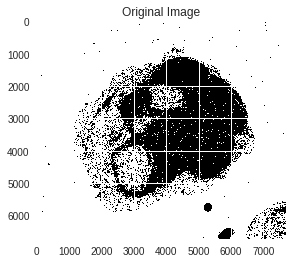

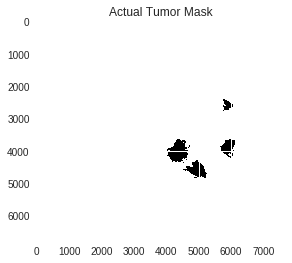

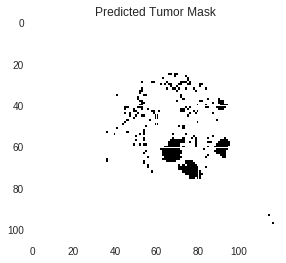

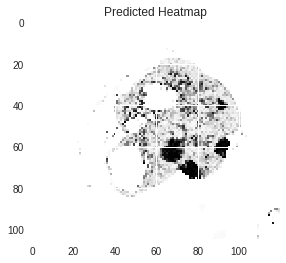

In [0]:
fig1, ax1 = plt.subplots()
plt.imshow(tissue_regions_091_L3)
ax1.set_title("Original Image")

fig2, ax2 = plt.subplots()
plt.imshow(mask_image_091_L3)
ax2.set_title("Actual Tumor Mask")

fig3, ax3 = plt.subplots()
plt.imshow(predictions)
ax3.set_title("Predicted Tumor Mask")

fig3, ax3 = plt.subplots()
plt.imshow(probabilities)
ax3.set_title("Predicted Heatmap")

In [0]:
predictions.shape

(105, 120)

Precision: 0.8229082612204013
Recall: 0.730507130232405
F1: 0.7739595676162921
AUC score 0.860713142189962


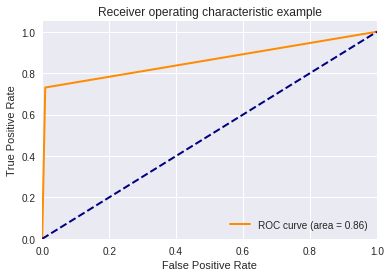

Confusion Matrix:
           Predicted 0  Predicted 1
Reality 0     12501114       114561
Reality 1       196387       532341
           Predicted 0  Predicted 1
Reality 0    93.680579     0.858495
Reality 1     1.471681     3.989246


In [0]:
def evaluate_result(predictions, tissue_regions, mask_image):
    scale = int(mask_image.shape[0]/predictions.shape[0])
    predictions_scaled = np.kron(predictions, np.ones((scale, scale)))
    predictions_scaled = predictions_scaled.reshape(-1)
    
    mask_image = mask_image.reshape(-1)
    tissue_regions = tissue_regions.reshape(-1)
  
    predictions_scaled = predictions_scaled[tissue_regions == 1]
    mask_image = mask_image[tissue_regions == 1]
  
    p = metrics.precision_score(mask_image, predictions_scaled)
    print('Precision:', p)
    r = metrics.recall_score(mask_image, predictions_scaled)
    print('Recall:', r)
    f = metrics.f1_score(mask_image, predictions_scaled)
    print('F1:', f)
    auc = metrics.roc_auc_score(mask_image, predictions_scaled)
    print('AUC score:', auc)
  
    fpr, tpr, _ = metrics.roc_curve(mask_image, predictions_scaled)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
  
    cm = metrics.confusion_matrix(mask_image, predictions_scaled)
    df_cm = pd.DataFrame(cm,columns = ['Predicted 0', 'Predicted 1'])
    df_cm.index = ['Reality 0', 'Reality 1']
    print('Confusion Matrix:')
    df_cm = pd.DataFrame(cm,columns = ['Predicted 0', 'Predicted 1'])
    df_cm.index = ['Reality 0', 'Reality 1']
    print(df_cm)
    df_cm_percent = df_cm
    df_cm_percent['Predicted 0'] = 100*df_cm_percent['Predicted 0']/len(mask_image)
    df_cm_percent['Predicted 1'] = 100*df_cm_percent['Predicted 1']/len(mask_image)
    print(df_cm_percent)
    
evaluate_result(predictions, tissue_regions_091_L3, mask_image_091_L3)

# InceptionV3


## Train

In [0]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

model2 = models.Sequential()
model2.add(base_model)
model2.add(layers.Flatten())
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dense(2, activation='softmax'))
model2.summary()

model2.compile(optimizer=tf.train.AdamOptimizer(),
               loss=tf.keras.losses.sparse_categorical_crossentropy,
               metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2, 2, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                262176    
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 66        
Total params: 22,065,026
Trainable params: 262,242
Non-trainable params: 21,802,784
_________________________________________________________________


In [0]:
history2 = model2.fit(ds_091_L3, epochs=8, steps_per_epoch=int(np.ceil(len(ImagePaths_091_L3)/BATCH_SIZE)))

Epoch 1/8
17/17 [==============================] - 127s 7s/step - loss: 0.6053 - acc: 0.7188
Epoch 2/8
17/17 [==============================] - 123s 7s/step - loss: 0.5998 - acc: 0.7445
Epoch 3/8
17/17 [==============================] - 124s 7s/step - loss: 0.5970 - acc: 0.7316
Epoch 4/8
17/17 [==============================] - 122s 7s/step - loss: 0.5726 - acc: 0.7610
Epoch 5/8
17/17 [==============================] - 122s 7s/step - loss: 0.5619 - acc: 0.7592
Epoch 6/8
17/17 [==============================] - 123s 7s/step - loss: 0.5449 - acc: 0.7794
Epoch 7/8
17/17 [==============================] - 121s 7s/step - loss: 0.5616 - acc: 0.7537
Epoch 8/8
17/17 [==============================] - 122s 7s/step - loss: 0.5699 - acc: 0.7702


{'loss': [0.6052770965239581, 0.5998327837270849, 0.5970358620671665, 0.5725897480459774, 0.5618933649624095, 0.5448883070665247, 0.561552528072806, 0.5699426724630243], 'acc': [0.71875, 0.7444852941176471, 0.7316176470588235, 0.7610294117647058, 0.7591911764705882, 0.7794117647058824, 0.7536764705882353, 0.7702205882352942]}


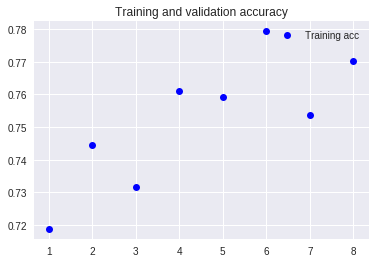

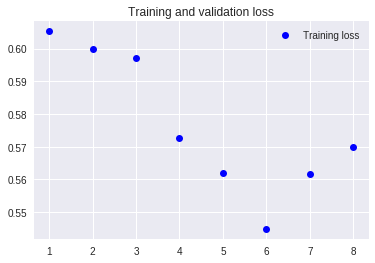

In [0]:
print(history2.history)

acc = history2.history['acc']
loss = history2.history['loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Test

In [0]:
test = model2.predict(ds_test, steps = int(np.ceil(len(ImagePaths_test)/BATCH_SIZE )))

In [0]:
img_num = np.zeros(len(ImagePaths_test))
for i in range(len(ImagePaths_test)):
    img_num[i] = int(ImagePaths_test[i].strip('.jpg').split('/')[-1].split('_')[-1])
    
depth, width = int(np.ceil(slide_image_091_L3.shape[0]/num_pixels)), int(np.ceil(slide_image_091_L3.shape[1]/num_pixels))
print(depth, width)

probabilities = np.zeros((depth, width))
predictions = np.zeros((depth, width))
conf_threshold = 0.6
for i in range(len(ImagePaths_test)):
    y = int(img_num[i] // width)
    x = int(np.mod(img_num[i], width))
    probabilities[y,x] = test[i][1]
    predictions[y,x] = int(test[i][1] > conf_threshold)

105 120


Text(0.5,1,'Predicted Heatmap')

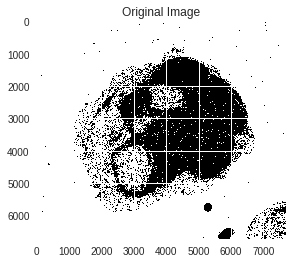

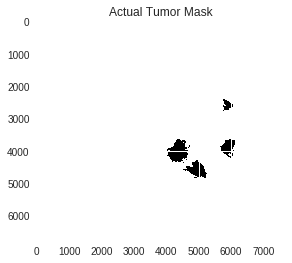

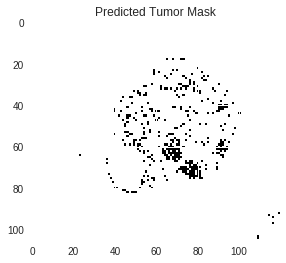

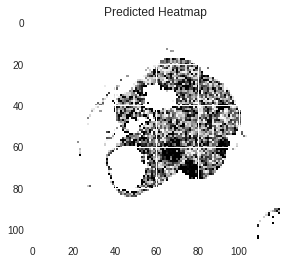

In [0]:
fig1, ax1 = plt.subplots()
plt.imshow(tissue_regions_091_L3)
ax1.set_title("Original Image")

fig2, ax2 = plt.subplots()
plt.imshow(mask_image_091_L3)
ax2.set_title("Actual Tumor Mask")

fig3, ax3 = plt.subplots()
plt.imshow(predictions)
ax3.set_title("Predicted Tumor Mask")

fig3, ax3 = plt.subplots()
plt.imshow(probabilities)
ax3.set_title("Predicted Heatmap")

Precision: 0.3175437996878416
Recall: 0.6502234029706557
F1: 0.42670263976308903
AUC score 0.7847509994222199


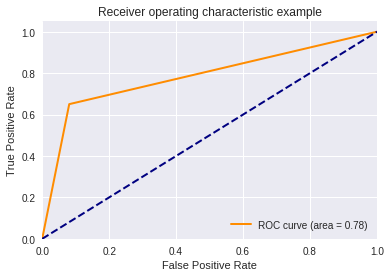

Confusion Matrix:
           Predicted 0  Predicted 1
Reality 0     11597320      1018355
Reality 1       254892       473836
           Predicted 0  Predicted 1
Reality 0    86.907747     7.631327
Reality 1     1.910104     3.550822


In [0]:
evaluate_result(predictions, tissue_regions_091_L3, mask_image_091_L3)